# Task 1: Pruning:

This notebook focuses on model compression using pruning.

## Setup:

### Installing Dependencies:

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


### Imports:

In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
# Check CUDA
assert torch.cuda.is_available(), (
    "CUDA not available. Please enable GPU runtime "
    "(Runtime -> Change runtime type -> GPU)."
)

In [3]:
# seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

### Function for downloading datset into the current environment:

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

### Loading pre-trained `VGG-11` and `CIFAR-10`

In [5]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")

Downloading: "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


## `VGG-11`:
`M`: maxpool

In [6]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

Training:

In [7]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

Evaluation:

In [8]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [9]:
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


### Loading CIFAR-10

In [10]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


#### Helper Functions:

In [11]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

### Testing Function:

In [12]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

## Evaluting Dense Model

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


## Function for plotting weights distribution:

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()


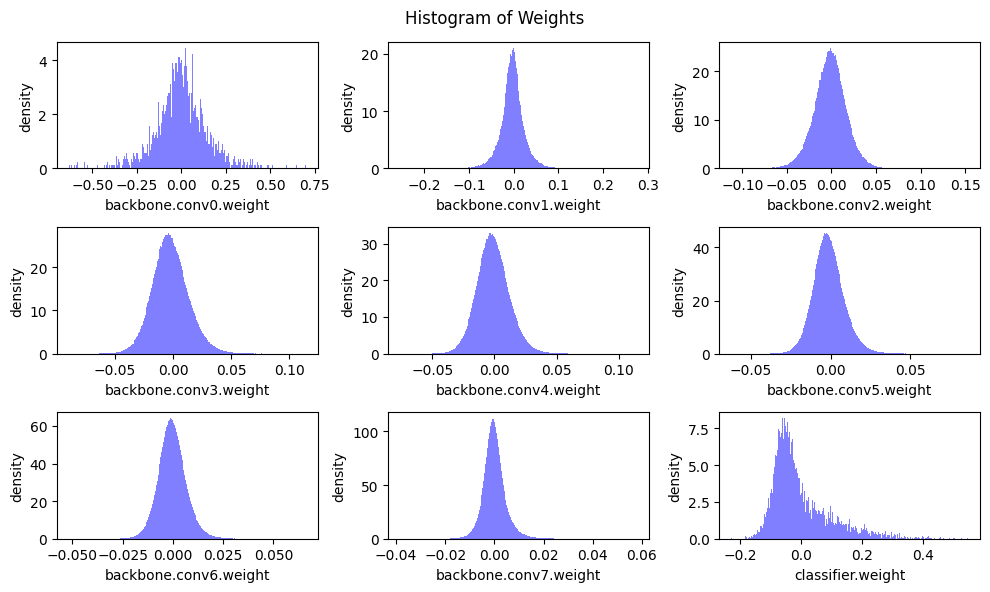

In [ ]:
plot_weight_distribution(model)

# Unstructured Pruning

This function takes in a weights tensor and sparsity value, and returns the mask for the weights tensor.

In [13]:
# sightly modified from the reference course assignment
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)
    num_elements = tensor.numel()
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(sparsity * num_elements)
    # Step 2: calculate the importance of weight
    importance = tensor.pow(2).flatten()
    # Step 3: calculate the pruning threshold
    threshold, _ = torch.kthvalue(importance, num_zeros)
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold).view(tensor.shape)
    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)
    return mask

Testing:

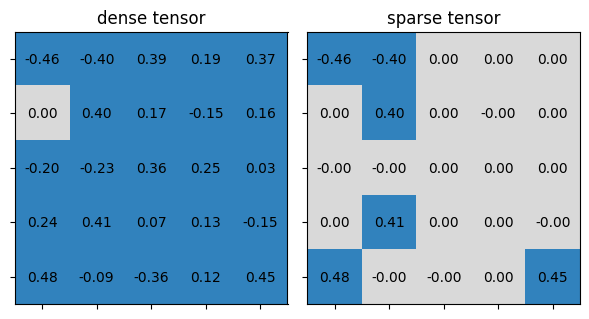

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [ ]:
test_fine_grained_prune()

## `FineGrainedPruner` Class:

In [14]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [ ]:
sparsity_dict = {}
for name, param in model.named_parameters():
    if param.dim() > 1:  # conv or fc layer
        sparsity_dict[name] = 0.5  # 50% sparsity for all for now, later we change this

Weight distribution before pruning:


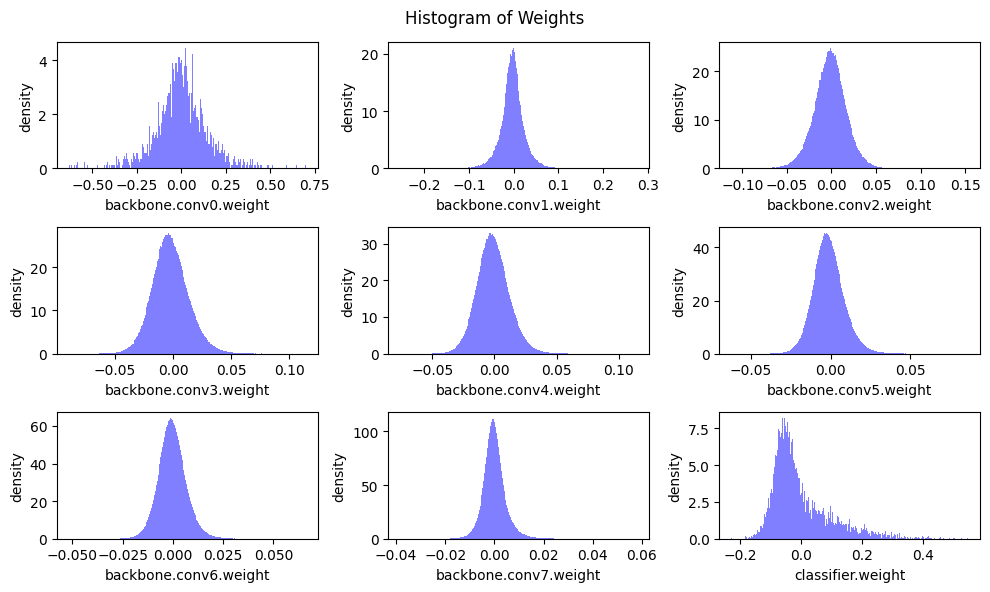

In [ ]:
# Recover dense model weights
recover_model()

print("Weight distribution before pruning:")
plot_weight_distribution(model)

Weight distribution after pruning:


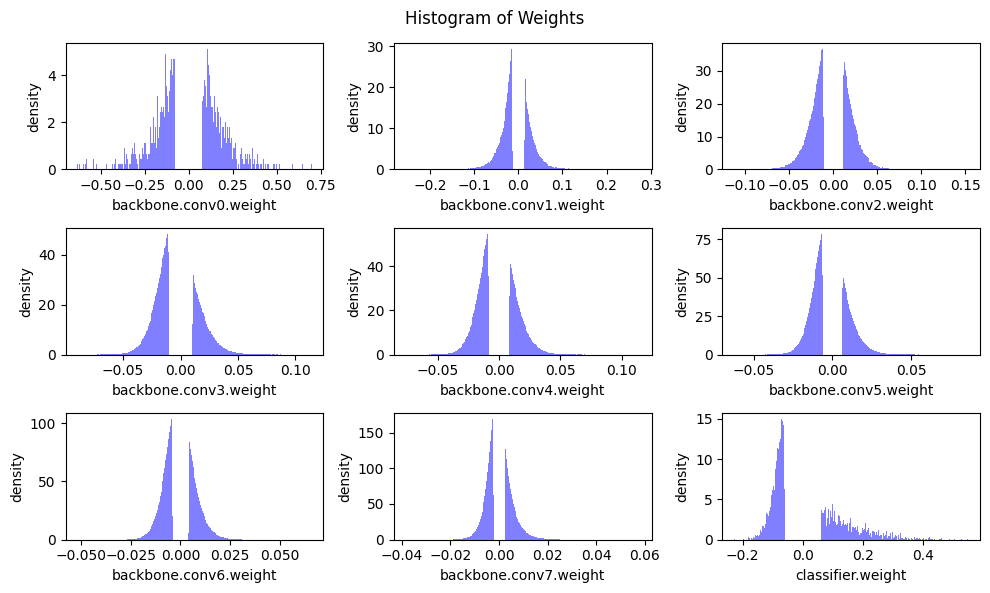

Overall model sparsity: 0.50


In [ ]:
# Apply pruning
pruner = FineGrainedPruner(model, sparsity_dict)

# Plot after pruning
print("Weight distribution after pruning:")
plot_weight_distribution(model, count_nonzero_only=True)

# Check sparsity
print(f"Overall model sparsity: {get_model_sparsity(model):.2f}")

In [ ]:
pruned_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Pruned model size = {pruned_model_size / MiB:.2f} MiB")
pruned_accuracy = evaluate(model, dataloader['test'])
print(f"Pruned model accuracy = {pruned_accuracy:.2f}%")

Pruned model size = 17.61 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Pruned model accuracy = 90.66%


## Sensitivity Analysis:

Now, we perform a sensitivity analysis to show that sensitivities to pruning vary across layers.

In [ ]:
recover_model()

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

### Plotting the sensitivities:

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

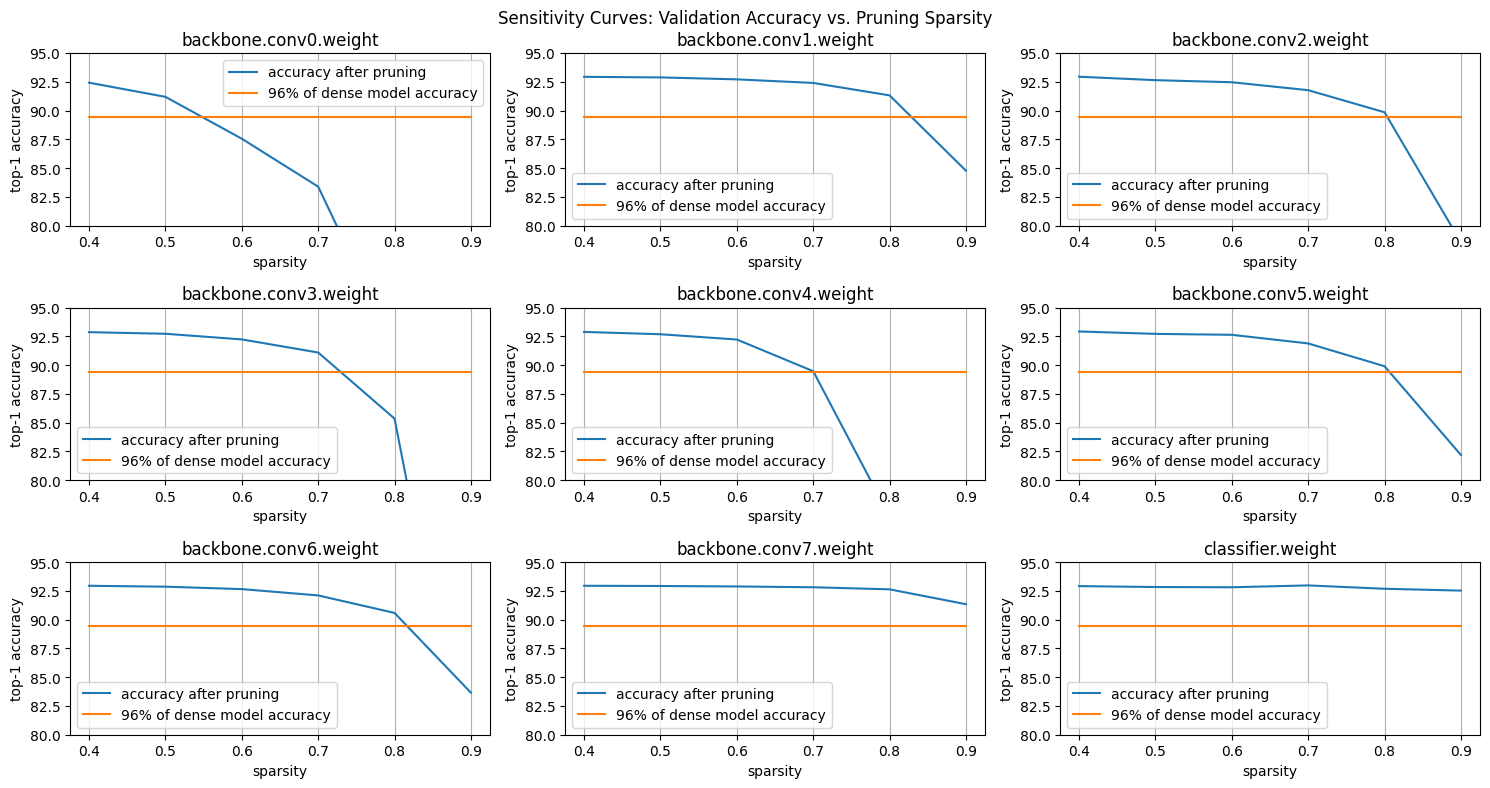

In [ ]:
plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

#### Plotting Sensitivities in one figure for clarity

In [ ]:
import itertools
def plot_overall_sensitivity(sparsities, accuracies, dense_model_accuracy, model):
    plt.figure(figsize=(10, 6))
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    layer_names = [name for name, p in model.named_parameters() if p.dim() > 1]
    markers = itertools.cycle(('o', 's', '^', 'D', 'v', '*', 'x', 'P', 'h', '>'))
    for i, layer_acc in enumerate(accuracies):
        plt.plot(
            sparsities, layer_acc,
            label=layer_names[i],
            marker=next(markers),
            linewidth=1.5
        )
    plt.axhline(lower_bound_accuracy, color='orange', linestyle='--', label='96% of dense model accuracy')
    plt.title("Sensitivity Curves (All Layers): Accuracy vs Sparsity")
    plt.xlabel("Sparsity")
    plt.ylabel("Validation Accuracy (%)")
    plt.grid(True, axis='x')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

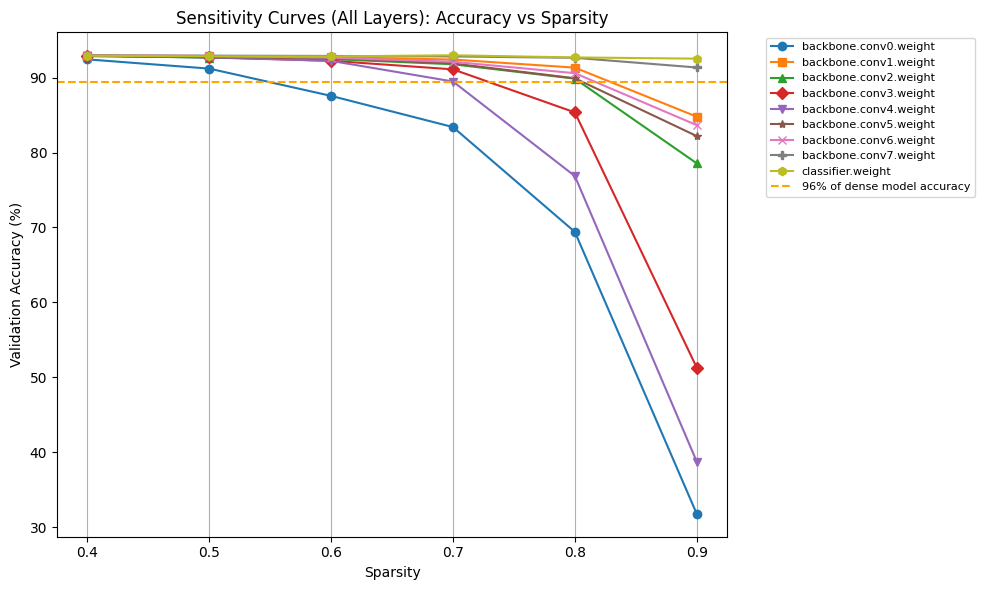

In [ ]:
plot_overall_sensitivity(sparsities, accuracies, dense_model_accuracy, model)

This shows an interesting observation that the second and third layer convolution layers (i.e., conv1 and conv2) are less sensitive as compared to the fourth and fifth convolution layers (i.e., conv3 and conv4). This implies that even the second and third layers have learned some redundant features, and the fouth and fifth layers are learning unique, useful features. \
The rest of the observations match the expectations perfectly.

#### Incorporating number of parameters as well:

In [ ]:
recover_model()

<All keys matched successfully>

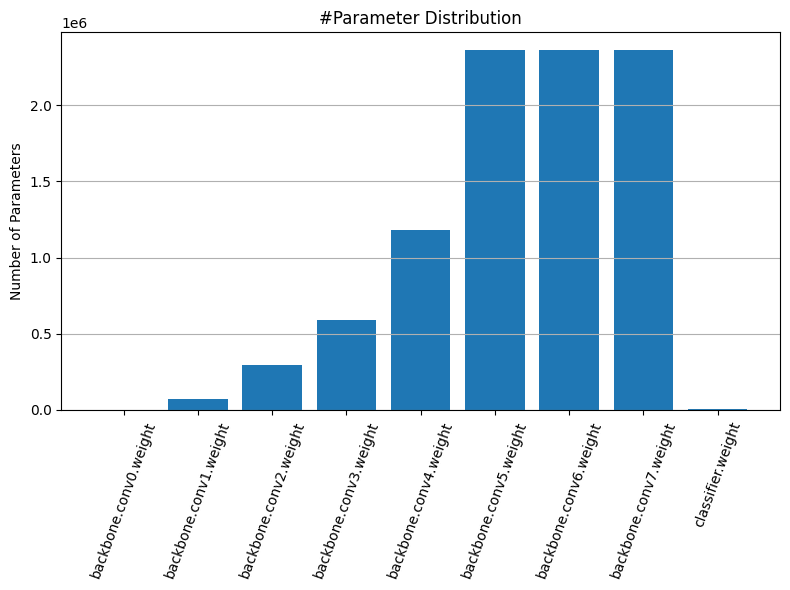

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()
plot_num_parameters_distribution(model)

# Setting sparsity and fine-tuning the model

In [ ]:
recover_model()
sparsity_dict = {
    'backbone.conv0.weight': 0.40,
    'backbone.conv1.weight': 0.55,
    'backbone.conv2.weight': 0.55,
    'backbone.conv3.weight': 0.50,
    'backbone.conv4.weight': 0.45,
    'backbone.conv5.weight': 0.75,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.75,
    'classifier.weight': 0.8
}

Helper function to get total sparsity from a dictionary

In [ ]:
@torch.no_grad()
def compute_global_sparsity(model, sparsity_dict):
    total_params = 0
    total_zero_params = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:  # conv/fc
            num_params = param.numel()
            total_params += num_params
            total_zero_params += num_params * sparsity_dict[name]
    global_sparsity = total_zero_params / total_params
    print(f"Estimated global sparsity = {global_sparsity * 100:.2f}%")
    return global_sparsity
compute_global_sparsity(model, sparsity_dict)

Estimated global sparsity = 70.04%


0.7003990090696496

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.55
  backbone.conv2.weight: 0.55
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.45
  backbone.conv5.weight: 0.75
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.75
  classifier.weight: 0.80
The sparsity of each layer becomes
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.55
  backbone.conv2.weight: 0.55
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.45
  backbone.conv5.weight: 0.75
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.75
  classifier.weight: 0.80
Sparse model has size=10.56 MiB = 30.00% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=89.01% before finetuning


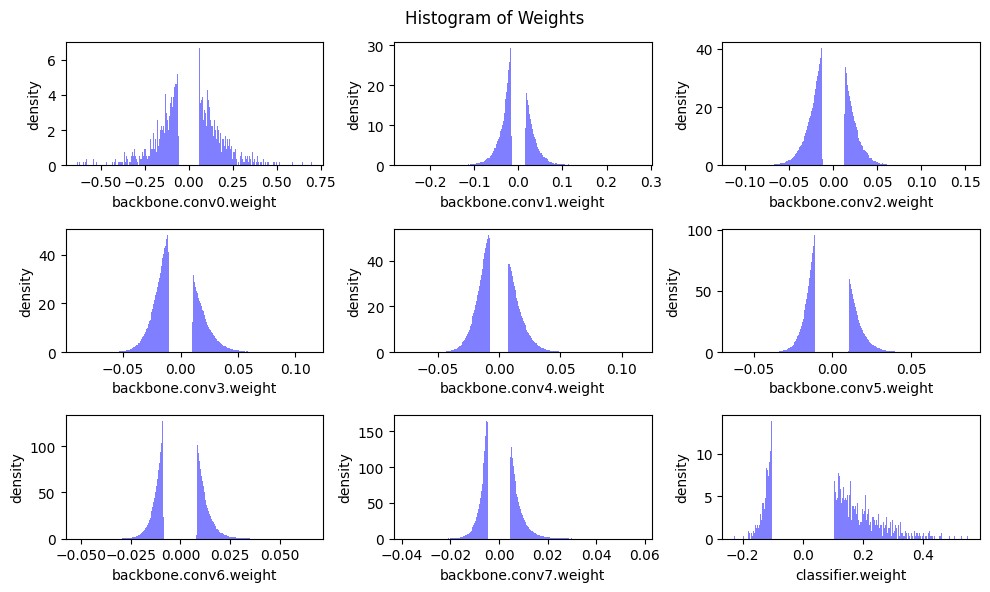

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before finetuning")
plot_weight_distribution(model, count_nonzero_only=True)

### Fine-tuning to increase accuracy:

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.59% / Best Accuracy: 92.59%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.79% / Best Accuracy: 92.79%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.76% / Best Accuracy: 92.79%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.93% / Best Accuracy: 92.93%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.89% / Best Accuracy: 92.93%


In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after finetuning")

Sparse model has size=10.56 MiB = 30.00% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.93% after finetuning


In [ ]:
# saving both model weights and sparsity info
torch.save({
    'state_dict': model.state_dict(),
    'sparsity_dict': sparsity_dict,
}, 'vgg11_sparse_unstructured.pth')

print("Model and sparsity info saved to 'vgg11_sparse_unstructured.pth'")

Model and sparsity info saved to 'vgg11_sparse_unstructured.pth'


# Structured Pruning:

Main benefit of structured pruning is inference speed up on GPUs.

In [ ]:
# firstly, let's restore the model weights to the original dense version
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


### Naive Structured Pruning:

Here, we first implement a very basic version of structured pruning which only keeps the first output_channels_to_keep and discards the rest. Later, we will make magnitude-based pruning (Frobenius Norm).

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    return int(round(channels * (1. - prune_ratio)))

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])

    return model


### Testing the Naive Model:

In [ ]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


Evaluation:

In [ ]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%


### Magnitude-based Structured Pruning:



We sort the channels based on their importance (magnitude by frobenius norm and keep the top $k$)

In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight, p='fro')
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    for i_conv in range(len(all_convs) - 1):
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        importance = get_input_channel_importance(next_conv.weight)
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

    return model

### Testing the Magnitude-Based Model:

In [ ]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


Evaluation:

In [ ]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%


### Fine-tuning to improve accuracy:

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.61% / Best Accuracy: 91.61%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 91.96% / Best Accuracy: 91.96%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.28% / Best Accuracy: 92.28%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.18% / Best Accuracy: 92.28%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.24% / Best Accuracy: 92.28%


### Plotting the distribution of weights:

In [ ]:
def plot_weight_distribution_structured(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3, 3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            param_cpu = param.detach().cpu().reshape(-1)
            if count_nonzero_only:
                param_cpu = param_cpu[param_cpu != 0]
            ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
            if plot_index >= len(axes):
                break
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

Weight distribution BEFORE structured pruning:


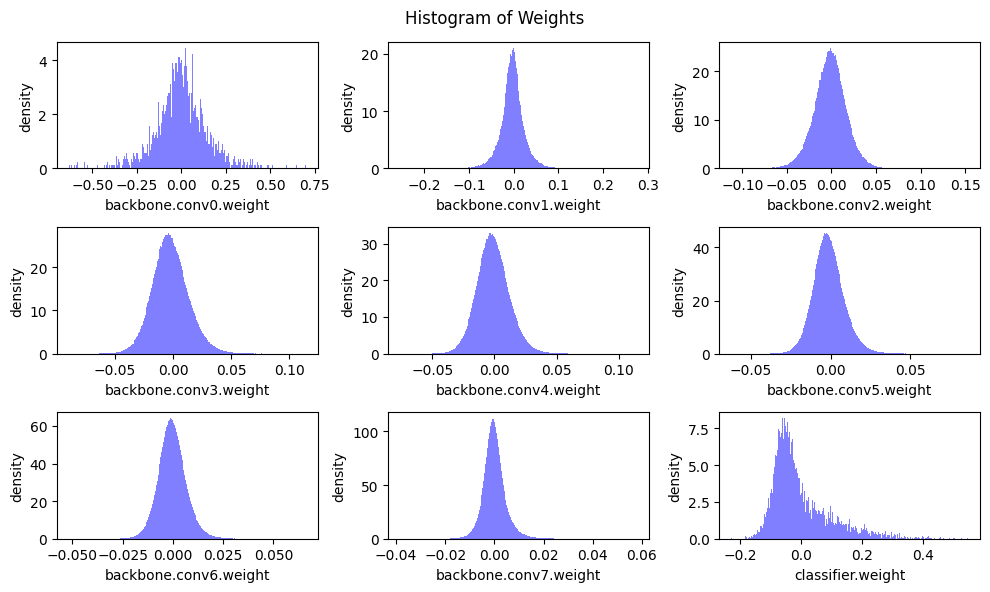

In [ ]:
# Recover dense model
recover_model()
print("Weight distribution BEFORE structured pruning:")
plot_weight_distribution_structured(model)

Weight distribution AFTER structured pruning (fine-tuned):


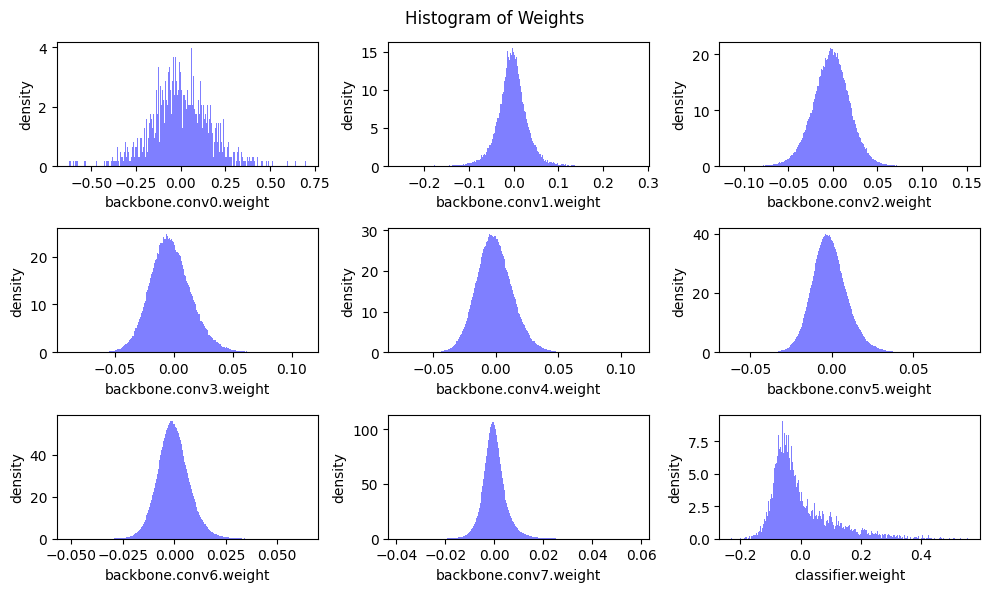

In [ ]:
print("Weight distribution AFTER structured pruning (fine-tuned):")
plot_weight_distribution_structured(pruned_model)

Weight distribution AFTER structured pruning (fine-tuned):


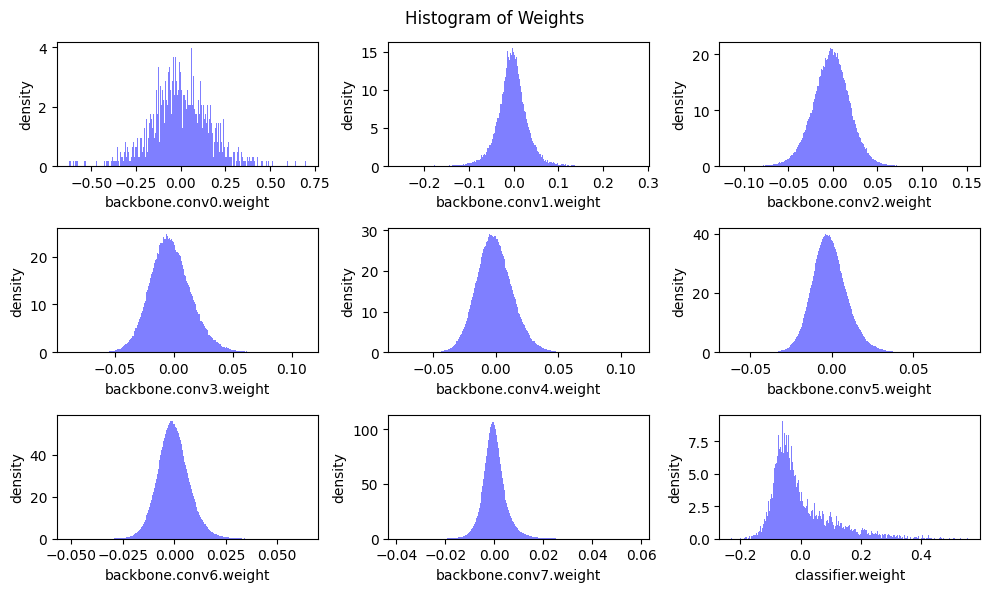

In [ ]:
print("Weight distribution AFTER structured pruning (fine-tuned):")
plot_weight_distribution_structured(pruned_model, count_nonzero_only=True)

As we can see, there is no difference between counting non zeros weights only or counting all weights as structured pruning doesn't make weights zero.

## Sensitivity Analysis:

In [ ]:
@torch.no_grad()
def structured_sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.1, scan_end=0.7, verbose=True):
    prune_ratios = np.arange(start=scan_start, stop=scan_end + 1e-6, step=scan_step)
    accuracies = []
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    n_conv = len(all_convs)

    for i_layer in range(n_conv - 1):
        accuracy_list = []
        if verbose:
            print(f"\nScanning layer {i_layer}/{n_conv-1} ({all_convs[i_layer]})")

        for prune_ratio in prune_ratios:
            pruned_model = channel_prune(model, [prune_ratio if j == i_layer else 0.0 for j in range(n_conv - 1)])
            acc = evaluate(pruned_model, dataloader, verbose=False)
            accuracy_list.append(acc)
            if verbose:
                print(f"  Prune ratio={prune_ratio:.2f} -> Acc={acc:.2f}%")

        accuracies.append(accuracy_list)
    return prune_ratios, accuracies

In [ ]:
def plot_structured_sensitivity(prune_ratios, accuracies, dense_model_accuracy, model):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)), figsize=(15, 8))
    axes = axes.ravel()
    all_convs = [name for name, m in model.named_modules() if isinstance(m, nn.Conv2d)]
    plot_index = 0

    for name, acc_list in zip(all_convs[:-1], accuracies):
        ax = axes[plot_index]
        ax.plot(prune_ratios, acc_list, marker='o', label='Accuracy')
        ax.axhline(lower_bound_accuracy, color='orange', linestyle='--',
                   label='96% of dense model accuracy')
        ax.set_title(name)
        ax.set_xlabel('Prune ratio (fraction of channels removed)')
        ax.set_ylabel('Validation Accuracy (%)')
        ax.set_ylim(80, 95)
        ax.grid(axis='x')
        ax.legend(fontsize=8)
        plot_index += 1

    fig.suptitle('Structured Sensitivity Curves: Accuracy vs Channel Prune Ratio')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

eval:   0%|          | 0/20 [00:00<?, ?it/s]


Scanning layer 0/7 (Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False))
  Prune ratio=0.10 -> Acc=92.59%
  Prune ratio=0.20 -> Acc=91.47%
  Prune ratio=0.30 -> Acc=90.15%
  Prune ratio=0.40 -> Acc=86.30%
  Prune ratio=0.50 -> Acc=75.50%
  Prune ratio=0.60 -> Acc=63.33%
  Prune ratio=0.70 -> Acc=27.73%

Scanning layer 1/7 (Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False))
  Prune ratio=0.10 -> Acc=91.60%
  Prune ratio=0.20 -> Acc=90.68%
  Prune ratio=0.30 -> Acc=85.52%
  Prune ratio=0.40 -> Acc=76.46%
  Prune ratio=0.50 -> Acc=69.51%
  Prune ratio=0.60 -> Acc=59.75%
  Prune ratio=0.70 -> Acc=41.92%

Scanning layer 2/7 (Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False))
  Prune ratio=0.10 -> Acc=91.67%
  Prune ratio=0.20 -> Acc=89.13%
  Prune ratio=0.30 -> Acc=85.73%
  Prune ratio=0.40 -> Acc=79.05%
  Prune ratio=0.50 -> Acc=64.47%
  Prune ratio=0.60 -> Acc=42.59%
  Prune ratio=0.70 -> Acc=23.87%

Scan

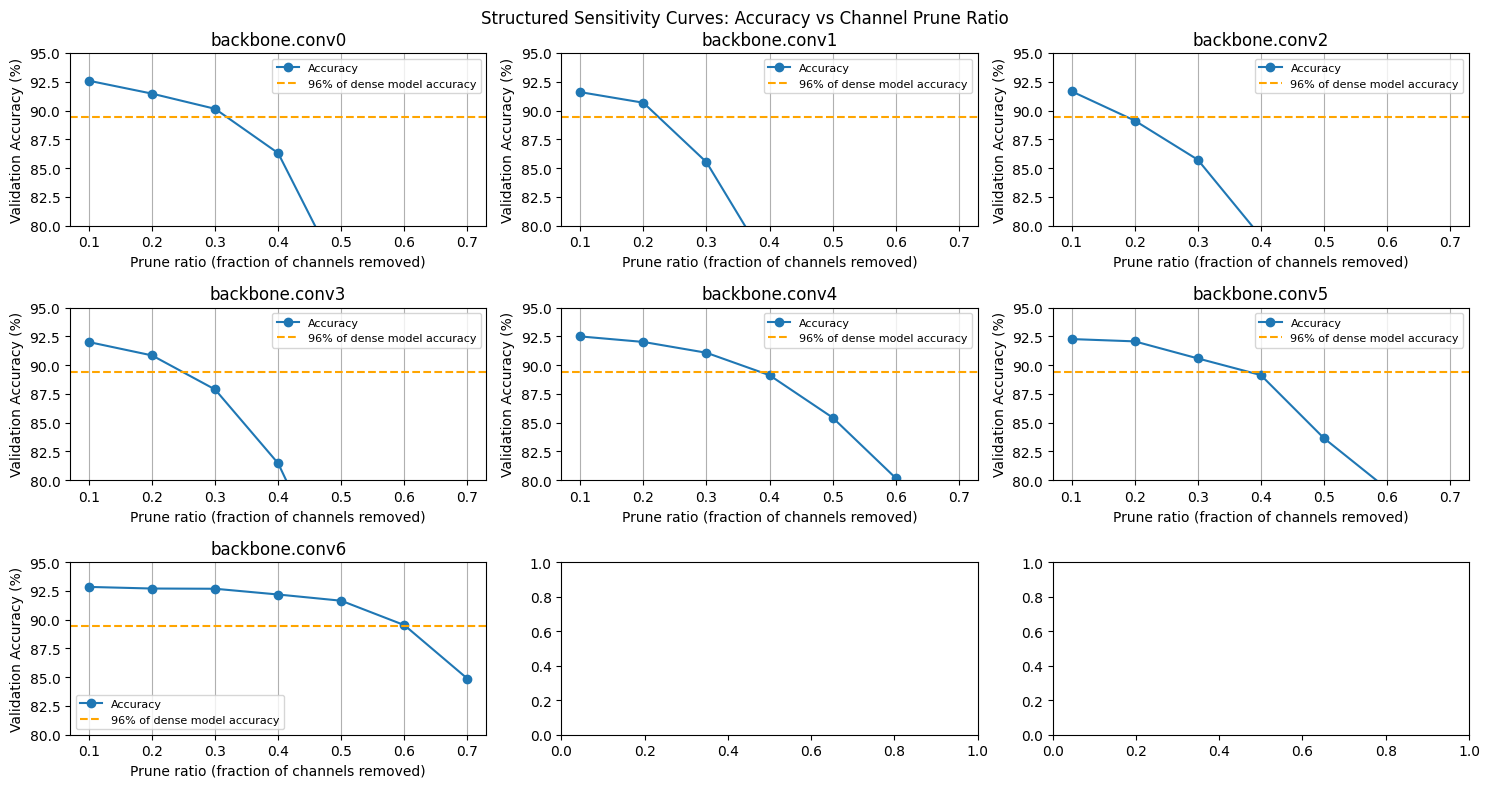

In [ ]:
recover_model()
dense_acc = evaluate(model, dataloader['test'])
prune_ratios, accuracies = structured_sensitivity_scan(model, dataloader['test'], scan_step=0.1, scan_start=0.1, scan_end=0.7)
plot_structured_sensitivity(prune_ratios, accuracies, dense_acc, model)

In [ ]:
import itertools
def plot_overall_structured_sensitivity(prune_ratios, accuracies, dense_model_accuracy, model):
    plt.figure(figsize=(10, 6))
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    layer_names = [name for name, m in model.named_modules() if isinstance(m, nn.Conv2d)]
    markers = itertools.cycle(('o', 's', '^', 'D', 'v', '*', 'x', 'P', 'h', '>'))
    for i, layer_acc in enumerate(accuracies):
        plt.plot(
            prune_ratios, layer_acc,
            label=layer_names[i],
            marker=next(markers),
            linewidth=1.5
        )
    plt.axhline(
        lower_bound_accuracy,
        color='orange',
        linestyle='--',
        label='96% of dense model accuracy'
    )

    plt.title("Structured Sensitivity Curves (All Layers): Accuracy vs Channel Prune Ratio")
    plt.xlabel("Prune Ratio (Fraction of Channels Removed)")
    plt.ylabel("Validation Accuracy (%)")
    plt.grid(True, axis='x')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

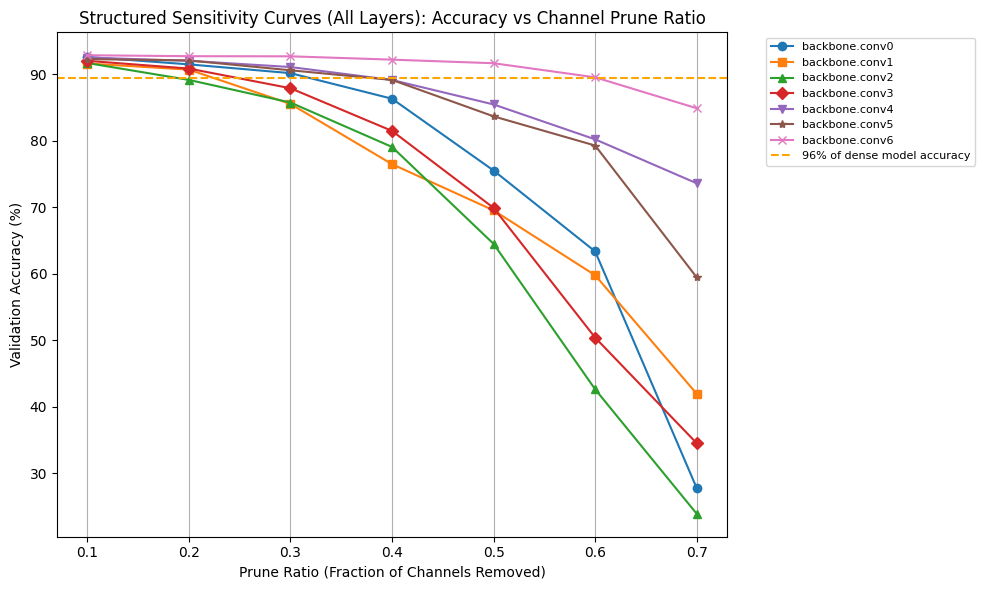

In [ ]:
plot_overall_structured_sensitivity(prune_ratios, accuracies, dense_acc, model)

#### Choosing pruning ratios manually

In [ ]:
# earlier layers are very sensitive, especially conv0 and conv2, so they will have the least pruning ratio.
# the later layers are relatively less sensitive, so they'll have bigger pruning ratio.
channel_pruning_ratio_custom = [
    0.2,  # conv0
    0.25, # conv1
    0.2,  # conv2
    0.3, # conv3
    0.35, # conv4
    0.4,  # conv5
    0.4,  # conv6
]


In [ ]:
print(" * With sorting and custom per-layer pruning ratios...")
for i, ratio in enumerate(channel_pruning_ratio_custom):
    print(f"  Conv Layer {i}: {ratio}")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio_custom)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"Pruned model has accuracy = {pruned_model_accuracy:.2f}%")
pruned_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Pruned model has size = {pruned_model_size / MiB:.2f} MiB = {pruned_model_size / (35.20*MiB) * 100:.2f}% of dense model size")

 * With sorting and custom per-layer pruning ratios...
  Conv Layer 0: 0.2
  Conv Layer 1: 0.25
  Conv Layer 2: 0.2
  Conv Layer 3: 0.3
  Conv Layer 4: 0.35
  Conv Layer 5: 0.4
  Conv Layer 6: 0.4


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Pruned model has accuracy = 43.67%
Pruned model has size = 16.33 MiB = 46.40% of dense model size


#### Finetuning to increase accuracy:

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_model = None
best_acc = 0
print(f"Fine-tuning channel-pruned model...")
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    acc = evaluate(pruned_model, dataloader['test'])
    if acc > best_acc:
        best_acc = acc
        best_model = copy.deepcopy(pruned_model)
    print(f"Epoch {epoch+1}: {acc:.2f}% (Best: {best_acc:.2f}%)")

Fine-tuning channel-pruned model...


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 91.37% (Best: 91.37%)


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: 91.93% (Best: 91.93%)


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: 92.01% (Best: 92.01%)


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: 91.99% (Best: 92.01%)


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: 92.31% (Best: 92.31%)


In [ ]:
# save both model weights and prune ratios
torch.save({
    'state_dict': best_model.state_dict(),
    'channel_prune_ratios': channel_pruning_ratio,
}, 'vgg11_sparse_structured.pth')
print("Structured-pruned model and pruning ratios saved to 'vgg11_sparse_structured.pth'")

Structured-pruned model and pruning ratios saved to 'vgg11_sparse_structured.pth'


In [ ]:
# checkpoint = torch.load('vgg11_sparse_unstructured.pth')
# # Step 1: create a new dense model
# model = VGG()

# # Step 2: load the pruned weights directly
# model.load_state_dict(checkpoint['state_dict'])

# # Step 3: optionally recover sparsity info
# sparsity_dict = checkpoint['sparsity_dict']

In [ ]:
# structured_checkpoint = torch.load('vgg11_sparse_structured.pth')
# structured_model.load_state_dict(structured_checkpoint['state_dict'])
# channel_pruning_ratio = structured_checkpoint['channel_prune_ratios']

# Comparison & Analysis:

Getting both the models from GitHub

In [ ]:
!wget https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_3/main/Task1/vgg11_sparse_unstructured.pth
!wget https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_3/main/Task1/vgg11_sparse_structured.pth

--2025-11-02 08:23:38--  https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_3/main/Task1/vgg11_sparse_unstructured.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36954109 (35M) [application/octet-stream]
Saving to: ‘vgg11_sparse_unstructured.pth’

vgg11_sparse_unstru 100%[===================>]  35.24M  --.-KB/s    in 0.1s    

2025-11-02 08:23:39 (301 MB/s) - ‘vgg11_sparse_unstructured.pth’ saved [36954109/36954109]

--2025-11-02 08:23:39--  https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_3/main/Task1/vgg11_sparse_structured.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199

In [ ]:
unstructured_ckpt = torch.load("vgg11_sparse_unstructured.pth", map_location="cuda")
structured_ckpt = torch.load("vgg11_sparse_structured.pth", map_location="cuda")

unstructured_model = VGG().cuda()
base_model = VGG().cuda()
sorted_model = apply_channel_sorting(base_model)
structured_model = channel_prune(sorted_model, channel_pruning_ratio_custom)
unstructured_model.load_state_dict(unstructured_ckpt['state_dict'])
structured_model.load_state_dict(structured_ckpt['state_dict'])

unstructured_model.eval()
structured_model.eval()

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [ ]:
print(f"Unstructured model accuracy: {evaluate(unstructured_model, dataloader['test']):.2f}%")
print(f"Structured model accuracy: {evaluate(structured_model, dataloader['test']):.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Unstructured model accuracy: 92.93%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Structured model accuracy: 92.31%


## Grad-CAM

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ae47db5ab9fd4e44e78875741a702c948fa65b2e95e51ee71e45faace501d02e
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import transforms

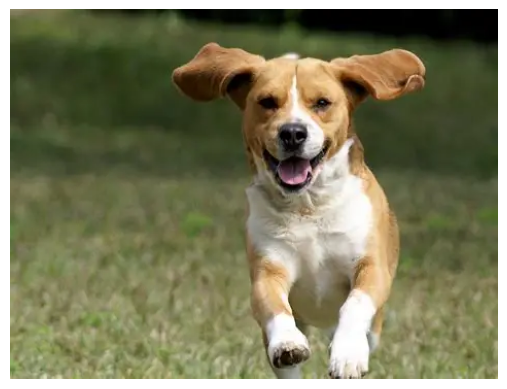

In [ ]:
# Fetch and display image
dog_url = "https://tse3.mm.bing.net/th/id/OIP.SPwDmj7siBHlEngxpeadlwHaFn?rs=1&pid=ImgDetMain&o=7&rm=3"
dog_image = Image.open(requests.get(dog_url, stream=True).raw).convert("RGB")
plt.imshow(dog_image)
plt.axis('off')
plt.show()

In [ ]:
# Transform image for model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(dog_image).unsqueeze(0).cuda()
rgb_img = np.float32(dog_image.resize((224, 224))) / 255


## Unstructured Grad-CAM:

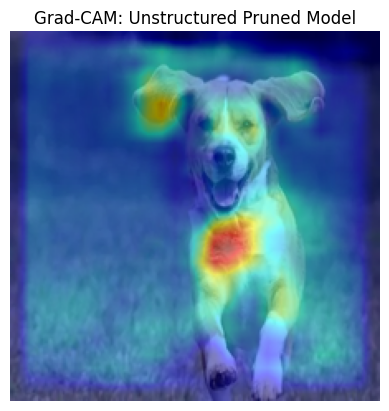

In [ ]:
unstructured_cam = GradCAM(model=unstructured_model, target_layers=[unstructured_model.backbone.conv7])
grayscale_cam = unstructured_cam(input_tensor=input_tensor)[0, :]
unstructured_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(unstructured_visualization)
plt.axis('off')
plt.title("Grad-CAM: Unstructured Pruned Model")
plt.show()

## Structured Grad-CAM:

In [ ]:
target_layer = structured_model.backbone.conv7

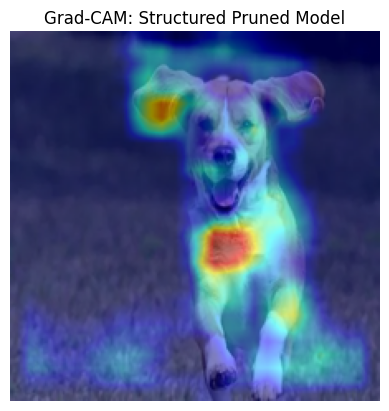

In [ ]:
structured_cam = GradCAM(model=structured_model, target_layers=[target_layer])
grayscale_cam = structured_cam(input_tensor=input_tensor)[0, :]

structured_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(structured_visualization)
plt.axis('off')
plt.title("Grad-CAM: Structured Pruned Model")
plt.show()

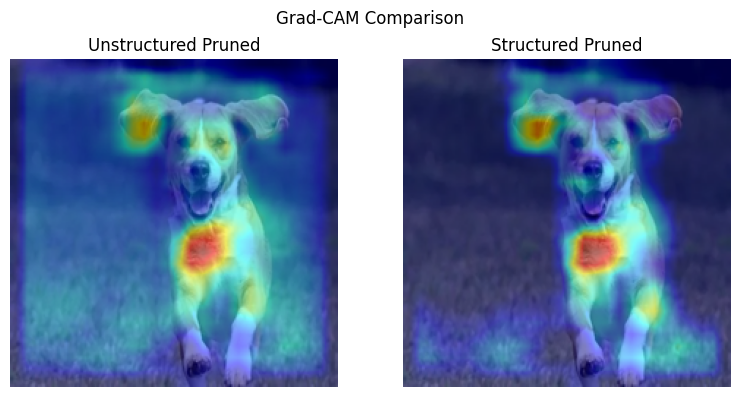

In [ ]:
# side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(unstructured_visualization)
axes[0].set_title("Unstructured Pruned")
axes[0].axis('off')
axes[1].imshow(structured_visualization)
axes[1].set_title("Structured Pruned")
axes[1].axis('off')
plt.suptitle("Grad-CAM Comparison")
plt.tight_layout()
plt.show()

Part (b) in report

## Part (c): Comparing inference times and storage:

In [ ]:
device = 'cpu'
dummy_input = torch.randn(1, 3, 32, 32).to(device)

original_model = VGG().to(device)
original_model.load_state_dict(checkpoint['state_dict'])
unstructured_model_cpu = unstructured_model.to(device)
structured_model_cpu = structured_model.to(device)

In [ ]:
@torch.no_grad()
def measure_latency(model, dummy_input, n_runs=5, n_warmup=20, n_test=100):
    times = []
    for _ in range(n_runs):
        # warm-up
        for _ in range(n_warmup):
            _ = model(dummy_input)
        start = time.time()
        for _ in range(n_test):
            _ = model(dummy_input)
        end = time.time()
        avg = (end - start) / n_test
        times.append(avg)
    return np.mean(times), np.std(times)

In [ ]:
table_template = "{:<20} {:<15} {:<15} {:<15}"
print(table_template.format('', 'Original', 'Unstructured', 'Structured'))
orig_lat, orig_std = measure_latency(original_model, dummy_input)
unstr_lat, unstr_std = measure_latency(unstructured_model_cpu, dummy_input)
str_lat, str_std = measure_latency(structured_model_cpu, dummy_input)
print(table_template.format('Latency (ms)',
                            f"{orig_lat*1000:.2f}±{orig_std*1000:.2f}",
                            f"{unstr_lat*1000:.2f}±{unstr_std*1000:.2f}",
                            f"{str_lat*1000:.2f}±{str_std*1000:.2f}"))

                     Original        Unstructured    Structured     
Latency (ms)         21.98±2.40      19.37±1.36      11.57±1.59     


In [ ]:
table_template = "{:<20} {:<15} {:<15} {:<15}"
print(table_template.format('', 'Original', 'Unstructured', 'Structured'))
orig_macs = get_model_macs(original_model, dummy_input)
unstr_macs = get_model_macs(unstructured_model_cpu, dummy_input)
str_macs = get_model_macs(structured_model_cpu, dummy_input)
print(table_template.format('MACs (M)',
                            round(orig_macs / 1e6, 2),
                            round(unstr_macs / 1e6, 2),
                            round(str_macs / 1e6, 2)))

                     Original        Unstructured    Structured     
MACs (M)             606.16          606.16          306.15         


In [ ]:
table_template = "{:<20} {:<15} {:<15} {:<15}"
print(table_template.format('', 'Original', 'Unstructured', 'Structured'))
orig_params = get_num_parameters(original_model)
unstr_params = get_num_parameters(unstructured_model_cpu)
str_params = get_num_parameters(structured_model_cpu)
print(table_template.format('Params (M)',
                            round(orig_params / 1e6, 2),
                            round(unstr_params / 1e6, 2),
                            round(str_params / 1e6, 2)))

                     Original        Unstructured    Structured     
Params (M)           9.23            9.23            4.28           


## Part (d): Accuracy vs. Sparsity

### Unstructured

In [15]:
@torch.no_grad()
def evaluate_unstructured_pruning_vs_sparsity(model, dataloader, sparsity_values):
    results = []
    for sparsity in sparsity_values:
        print(f"\nApplying unstructured pruning with sparsity={sparsity:.2f}...")
        pruned_model = copy.deepcopy(model)
        # define sparsity dict for each layer
        sparsity_dict = {}
        for name, param in pruned_model.named_parameters():
            if param.dim() > 1:  # conv or fc layer
                sparsity_dict[name] = sparsity

        # apply pruning
        pruner = FineGrainedPruner(pruned_model, sparsity_dict)
        pruner.apply(pruned_model)

        acc = evaluate(pruned_model, dataloader['test'], verbose=False)
        print(f"  Accuracy: {acc:.2f}%")
        results.append(acc)
    return results

def plot_unstructured_accuracy_vs_sparsity(sparsity_values, accuracies, dense_acc):
    plt.figure(figsize=(8, 6))
    plt.plot(sparsity_values, accuracies, marker='o', linewidth=2, color='royalblue', label='Unstructured Pruned')
    plt.axhline(y=dense_acc, color='gray', linestyle='--', label='Dense Model Accuracy')
    plt.title("Unstructured Pruning: Accuracy vs Sparsity")
    plt.xlabel("Sparsity (Fraction of Weights Set to Zero)")
    plt.ylabel("Validation Accuracy (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [16]:
model = VGG().cuda()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

92.94999694824219

Applying unstructured pruning with sparsity=0.40...
  Accuracy: 92.10%

Applying unstructured pruning with sparsity=0.50...
  Accuracy: 90.66%

Applying unstructured pruning with sparsity=0.60...
  Accuracy: 87.25%

Applying unstructured pruning with sparsity=0.70...
  Accuracy: 75.80%

Applying unstructured pruning with sparsity=0.80...
  Accuracy: 41.11%


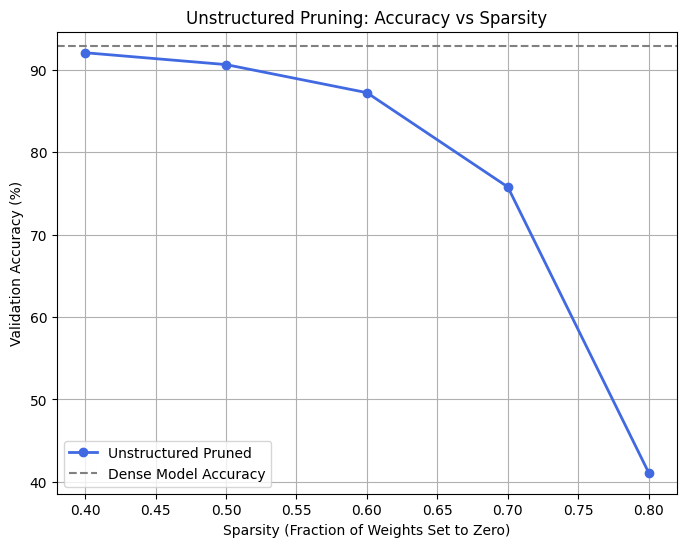

In [17]:
sparsity_values = [0.4, 0.5, 0.6, 0.7, 0.8]
dense_acc = evaluate(model, dataloader['test'], verbose=False)
print(dense_acc)
unstructured_accuracies = evaluate_unstructured_pruning_vs_sparsity(model, dataloader, sparsity_values)
plot_unstructured_accuracy_vs_sparsity(sparsity_values, unstructured_accuracies, dense_acc)

### Structured

In [ ]:
@torch.no_grad()
def evaluate_structured_pruning_vs_sparsity(model, dataloader, prune_ratios):
    accuracies = []
    for ratio in prune_ratios:
        print(f"\nApplying structured pruning with ratio={ratio:.2f}...")
        sorted_model = apply_channel_sorting(model)
        pruned_model = channel_prune(sorted_model, prune_ratio=ratio)
        acc = evaluate(pruned_model, dataloader, verbose=False)
        print(f"  Accuracy: {acc:.2f}%")
        accuracies.append(acc)
    return accuracies
def plot_accuracy_vs_sparsity(prune_ratios, accuracies, dense_acc):
    plt.figure(figsize=(8, 6))
    plt.plot(prune_ratios, accuracies, marker='o', linewidth=2, label='Pruned Model')
    plt.axhline(y=dense_acc, color='gray', linestyle='--', label='Dense Model Accuracy')
    plt.title("Structured Pruning: Accuracy vs Pruning Ratio")
    plt.xlabel("Pruning Ratio (Fraction of Channels Removed)")
    plt.ylabel("Validation Accuracy (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
model = VGG().cuda()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

eval:   0%|          | 0/20 [00:00<?, ?it/s]

92.94999694824219

Applying structured pruning with ratio=0.20...
  Accuracy: 52.01%

Applying structured pruning with ratio=0.30...
  Accuracy: 36.81%

Applying structured pruning with ratio=0.40...
  Accuracy: 19.78%

Applying structured pruning with ratio=0.50...
  Accuracy: 10.90%

Applying structured pruning with ratio=0.60...
  Accuracy: 10.37%


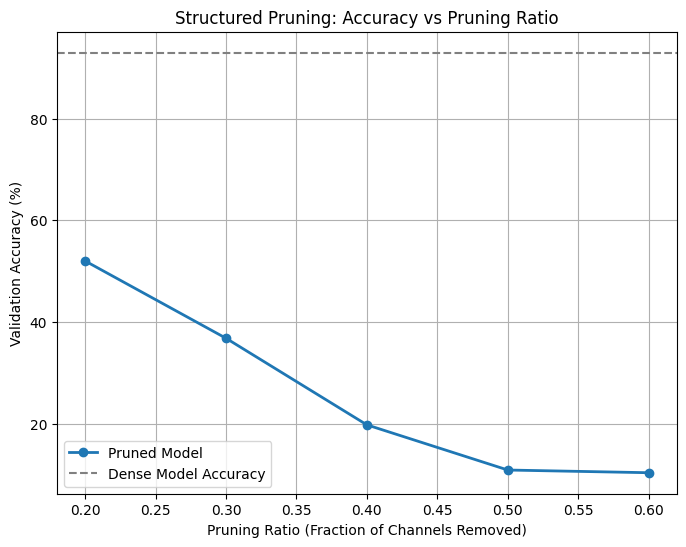

In [ ]:
prune_ratios = [0.2, 0.3, 0.4, 0.5, 0.6]
dense_acc = evaluate(model, dataloader['test'])
print(dense_acc)
structured_accuracies = evaluate_structured_pruning_vs_sparsity(model, dataloader['test'], prune_ratios)
plot_accuracy_vs_sparsity(prune_ratios, structured_accuracies, dense_acc)
